In [ ]:
# ==========================================
# Title:  Przewidywanie cen laptopów - zadanie rekrutacyjne Allegro
# Author: Magdalena Raczkiewicz
# Date:   24/04/2021
# ==========================================

# Przewidywanie cen laptopów
---

## Wprowadzenie 

Celem zadania jest stworzenie modelu pozwalającego przewidzieć cenę laptopa na podstawie jego atrybutów. 

W zadaniu podjęto następujące kroki:

1. Wczytanie danych 

2. Wstępna analiza i czyszczenie danych

3. Przygotowanie do modelowania

4. Wstępne dopasowanie modelu 

5. Tuning hyperparametrów

6. Interpretacja otrzymanych wyników

7. Podsumowanie

      

Poniżej przedstawiono zmienne, nowe nazwy kolumn (w nawiasie) oraz krótko opisane intuicje / hipotezy badawcze co do możliwej zależności od ceny laptopa:  

1. rodzaj karty graficznej (*grafika*) - grafika dedytkowana wiąże się z wyższą ceną 

2. komunikacja (*komunikacja*) - wi-fi, bluetooth, lan są zwykle w standardzie. Widi, modem LTE czy NFC mogą wiązać się z wyższą ceną   

3. rozdzielczość (piksele) (*rozdzielczosc*) - im większa tym wyższa cena

4. liczba rdzeni procesora (*rdzenie*) - im więcej tym wyższa cena

5. wielkość pamięci ram (*ram*) - im więcej tym wyższa cena 

6. system operacyjny (*system*) - im nowszy tym wyższa cena, wersje pro są odpowiednio droższe od wersji home, pominięto rozróżnienie na systemy 32 i 64-bitowe

7. typ dysku twardego (*typ_dysku*)- dyski SSD i hybrydowe wiążą się z wyższą ceną, eMMC są najtańsze

8. sterowanie (*sterowanie*) - podświetlana klawiatura wiąże się z wyższą ceną, pozostałe elementy są standardowe

9. multimedia (*multimedia*) - czytnik kart pamięci, kamera, głośniki i mikrofon są standardowymi elementami wyposażenia laptopa, nie przewiduje się istotnych zależności

10. typ pamięci ram (*typ_ram*) - DDR4 wiąże się z wyższą ceną, pozostałe DDR3, DDR3L (niskonapięciowe) są odpowiednio tańsze

11. taktowanie bazowe procesora (ghz) (*taktowanie*) - im większe tym wyższa cena 

12. seria procesora (*procesor*) - procesory najnowszych generacji (i5, i7) są najdroższe, procesory Intela są w poszczególnych generacjach odpowiednio droższe od procesorów AMD 

13. stan (*stan*) - nowe laptopy kosztują więcej niż używane (w zbiorze znajdują się tylko nowe laptopy więc zmienna zostanie)

14. pojemność dysku (gb) (*dysk*) - im większa tym wyższa cena, przy czym dysk SSD z mniejszą pojemnością będzie droższy od HDD z większą 

15. gwarancja (*gwarancja*) - gwarancja producenta wiąże się z wyższą ceną, brak gwarancji wiąże się z niższą ceną

16. wielkość matrycy (*matryca*) - mała matryca wiąże się z niższą ceną 

Spodziewane zależności: większe laptopy (od 15.6') przeważnie mają klawiaturę numeryczną

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [189]:
sns.set()

## 1. Wczytanie danych

In [190]:
df = pd.read_json("public-dataset.json")
df.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora', 'stan',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy '],
      dtype='object')

In [191]:
# pominięcie nieistotnych kolumn
df = df.drop(['stan'], axis=1)

# zmiana nazw kolumn
df = df.rename(columns={'buynow_price': 'cena', 
                        'rodzaj karty graficznej': 'grafika', 
                        'rozdzielczość (piksele)': 'rozdzielczosc', 
                        'liczba rdzeni procesora': 'rdzenie', 
                        'wielkość pamięci ram': 'ram', 
                        'system operacyjny': 'system', 
                        'typ dysku twardego': 'typ_dysku', 
                        'typ pamięci ram': 'typ_ram', 
                        'taktowanie bazowe procesora (ghz)': 'taktowanie', 
                        'seria procesora': 'procesor', 
                        'pojemność dysku (gb)': 'dysk', 
                        'wielkość matrycy ': 'matryca'}, inplace=False)

## 2. Wstępna analiza i czyszczenie danych

In [192]:
df.head()

,cena,grafika,komunikacja,rozdzielczosc,rdzenie,ram,system,typ_dysku,sterowanie,multimedia,typ_ram,taktowanie,procesor,dysk,gwarancja,matryca
70,1599.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.9,intel core i3,500.0,sprzedawcy,"13"" - 13.9"""
1489,2999.0,grafika dedykowana,"[nfc (near field communication), gps]",1920 x 1080,2,12 gb,[windows 10 home],None,[touchpad],"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,480.0,producenta,"15"" - 15.9"""
407,2999.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,16 gb,[windows 7 professional 64-bit],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,intel pentium dual-core,480.0,producenta,"15"" - 15.9"""
1359,2849.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,480.0,producenta,"15"" - 15.9"""
10567,2319.0,None,None,None,2,None,None,None,None,None,None,NaN,None,NaN,producenta,None


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7853 entries, 70 to 5978
Data columns (total 16 columns):
cena             7853 non-null float64
grafika          7357 non-null object
komunikacja      7071 non-null object
rozdzielczosc    7245 non-null object
rdzenie          7853 non-null object
ram              7403 non-null object
system           7203 non-null object
typ_dysku        7418 non-null object
sterowanie       7175 non-null object
multimedia       7145 non-null object
typ_ram          6989 non-null object
taktowanie       6917 non-null float64
procesor         7320 non-null object
dysk             7372 non-null float64
gwarancja        7853 non-null object
matryca          7507 non-null object
dtypes: float64(3), object(13)
memory usage: 1.0+ MB


### 2.1. Uzupełnienie brakujących danych
W treningowym zbiorze danych znajdują się braki. W kolejnym kroku sprawdzono ich procentowy stosunek.

In [194]:
df.isnull().mean()

cena             0.000000
grafika          0.063161
komunikacja      0.099580
rozdzielczosc    0.077423
rdzenie          0.000000
ram              0.057303
system           0.082771
typ_dysku        0.055393
sterowanie       0.086336
multimedia       0.090157
typ_ram          0.110022
taktowanie       0.119190
procesor         0.067872
dysk             0.061250
gwarancja        0.000000
matryca          0.044060
dtype: float64

In [195]:
df.loc[df['rdzenie'] == 'nie dotyczy'].head()

,cena,grafika,komunikacja,rozdzielczosc,rdzenie,ram,system,typ_dysku,sterowanie,multimedia,typ_ram,taktowanie,procesor,dysk,gwarancja,matryca
5422,5820.0,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,NaN,producenta,None
2052,2378.9,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,NaN,producenta,None
6261,6858.9,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,NaN,producenta,None
10911,2910.0,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,NaN,producenta,None
601,1398.9,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,NaN,producenta,None


Liczba brakujących danych wynosi od 0 do 12% na kolumnę. Jest to procent pozwalający na ręczną imputację (np. średnią w przypadku zmiennych ilościowych i modą w przypadku jakościowych). Mając na uwadze możliwość pojawienia się niechcianych zaburzeń po wypełnieniu braków modą, zdecydowano się ją zastosować ze względu na oszczędność czasu i konieczność powtórzenia czynności dla zbioru testowego.

In [196]:
# sprawdzenie wartości modalnych zmiennych
df.mode()

,cena,grafika,komunikacja,rozdzielczosc,rdzenie,ram,system,typ_dysku,sterowanie,multimedia,typ_ram,taktowanie,procesor,dysk,gwarancja,matryca
0,2999.0,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,1000.0,producenta,"15"" - 15.9"""


In [197]:
# uzupełnienie brakujących danych modą - wszystkie kolumny
col_list = df.columns.tolist()

for column in df:
    if df[column].isnull().any():
        df[column] = df[column].astype(str)
        df[column] = df[column].replace('None', df[column].mode()[0]).replace(np.nan, df[column].mode()[0]).replace('nan', df[column].mode()[0])

In [198]:
# czyszczenie kolumn z wielokrtonymi wartościami 
col_list = ['komunikacja', 'system', 'sterowanie', 'multimedia']

for col in col_list:
    df[col] = df[col].astype(str).str.replace(r"[\"\[\]\']", '')

In [199]:
df.head()

,cena,grafika,komunikacja,rozdzielczosc,rdzenie,ram,system,typ_dysku,sterowanie,multimedia,typ_ram,taktowanie,procesor,dysk,gwarancja,matryca
70,1599.0,grafika zintegrowana,"wi-fi, bluetooth, lan 10/100/1000 mbps",1366 x 768,2,8 gb,windows 10 home,hdd,"klawiatura, touchpad","czytnik kart pamięci, kamera, głośniki, mikrofon",ddr3,1.9,intel core i3,500.0,sprzedawcy,"13"" - 13.9"""
1489,2999.0,grafika dedykowana,"nfc (near field communication), gps",1920 x 1080,2,12 gb,windows 10 home,ssd,touchpad,"czytnik kart pamięci, kamera, głośniki, mikrofon",ddr4,2.0,intel core i3,480.0,producenta,"15"" - 15.9"""
407,2999.0,grafika zintegrowana,"wi-fi, bluetooth, lan 10/100/1000 mbps",1366 x 768,2,16 gb,windows 7 professional 64-bit,ssd,"klawiatura, touchpad, klawiatura numeryczna","czytnik kart pamięci, kamera, głośniki, mikrofon",ddr3l,2.1,intel pentium dual-core,480.0,producenta,"15"" - 15.9"""
1359,2849.0,grafika zintegrowana,"wi-fi, bluetooth, lan 10/100/1000 mbps",1920 x 1080,2,8 gb,windows 10 professional,ssd,"klawiatura, touchpad, klawiatura numeryczna","czytnik kart pamięci, kamera, głośniki, mikrofon",ddr4,2.0,intel core i3,480.0,producenta,"15"" - 15.9"""
10567,2319.0,grafika dedykowana,"wi-fi, bluetooth, lan 10/100/1000 mbps",1920 x 1080,2,8 gb,windows 10 home,ssd,"klawiatura, touchpad, klawiatura numeryczna","czytnik kart pamięci, kamera, głośniki, mikrofon",ddr4,2.5,intel core i5,1000.0,producenta,"15"" - 15.9"""


### 2.2. Grupowanie i czyszczenie zmiennych z wieloma kategoriami

Zmienne *komunikacja, rozdzielczosc, system, sterowanie, procesor* i *matryca* mają wiele kategorii, co utrudnia pracę z nimi i późniejsze modelowanie.  
Aby nie niepotrzebnie nie komplikować układu danych przeprowadzono grupowanie z uprzednim sprawdzeniem średnich, odchyleń i liczebności w grupach.  
Kolejność jest zgodna z występowaniem w zbiorze.   

In [200]:
def stats_per_group(df, x_col, y_col):
    display(df[[x_col, y_col]].groupby([x_col])\
        .agg(['mean', 'count', 'std'])\
        .reset_index()\
        .sort_values(by=('cena', 'mean'), ascending=False))

In [201]:
# 1. grafika
stats_per_group(df, 'grafika', 'cena')

grafika         cena                   
                                mean count          std
0    grafika dedykowana  4013.706727  4824  1654.830526
1  grafika zintegrowana  2618.419501  3029  1486.930538

In [202]:
# 2. komunikacja
stats_per_group(df, 'komunikacja', 'cena')

komunikacja         cena        \
                                                               mean count   
1      bluetooth, gps, modem 3g (wwan), modem 4g (lte)  9221.333333     3   
97   wi-fi, bluetooth, lan 10/100/1000 mbps, intel ...  9204.662500     4   
104  wi-fi, bluetooth, lan 10/100/1000 mbps, nfc (n...  8886.040000     1   
106  wi-fi, bluetooth, modem 3g (wwan), modem 4g (lte)  8784.674286    14   
85   wi-fi, bluetooth, gps, modem 3g (wwan), modem ...  8622.157500     4   
..                                                 ...          ...   ...   
69            wi-fi 802.11 b/g/n, lan 10/100/1000 mbps  1465.666667     3   
48                                               wi-fi  1344.083333    24   
36   lan 10/100 mbps, nfc (near field communication...  1179.900000     1   
68                 wi-fi 802.11 b/g/n, lan 10/100 mbps  1169.000000     1   
91   wi-fi, bluetooth, lan 10/100 mbps, modem 3g (w...  1099.000000     1   

                  
             std  
1     287.193895  
97   1574.060140  
104          NaN  
106  2468.903348  
85   1603.069218  
..           ...  
69    152.752523  
48    583.654969  
36           NaN  
68           NaN  
91           NaN  

[112 rows x 4 columns]

In [203]:
# komunikacja
df.loc[df["komunikacja"].str.contains('lte'), 'komunikacja'] = 'lte'
df.loc[~df["komunikacja"].str.contains('lte'), 'komunikacja'] = 'zwykle'

# komunikacja po zmianie
stats_per_group(df, 'komunikacja', 'cena')

komunikacja         cena                   
                      mean count          std
0         lte  5560.384120   267  2129.836000
1      zwykle  3402.147556  7586  1668.538404

In [204]:
# 3. rozdzielczosc
stats_per_group(df, 'rozdzielczosc', 'cena')

rozdzielczosc         cena                   
                         mean count          std
11   3840 x 2160  7527.887154   123  1635.365987
7    2560 x 1440  7491.170000    34  2976.330301
12          inna  6844.000000     2  2043.538598
5    1920 x 1280  5492.322258    31  2044.994952
6    2160 x 1440  4633.400000     5   823.396199
8    2560 x 1600  4499.000000     1          NaN
9    2880 x 1620  4418.427500     4   816.616118
3    1920 x 1080  3971.715565  5155  1574.626972
4    1920 x 1200  3835.042500     4  3508.427252
10   3200 x 1800  3755.058667    15   709.421907
2     1600 x 900  2738.361322   363   797.997023
1     1366 x 768  2061.626414  2100   760.902065
0     1280 x 800   880.868750    16   234.137557

In [205]:
vals_to_replace = {'3840 x 2160':'duza', '2560 x 1440':'duza', '1920 x 1280':'srednia', '2160 x 1440':'duza', '2560 x 1600':'duza', '2160 x 1440':'duza', '2880 x 1620':'duza', '1920 x 1080':'srednia', '3200 x 1800':'duza', '1920 x 1200':'srednia', '3200 x 1800':'duza', '1600 x 900':'mala', '1366 x 768':'mala', '1280 x 800':'mala', 'inna':'duza'}
df['rozdzielczosc'] = df['rozdzielczosc'].map(vals_to_replace)

# rozdzielczosc po zmianie
stats_per_group(df, 'rozdzielczosc', 'cena')

rozdzielczosc         cena                   
                        mean count          std
0          duza  7043.388533   184  2212.221432
2       srednia  3980.692852  5190  1583.593444
1          mala  2153.099851  2479   807.154545

In [206]:
# 4. rdzenie
df['rdzenie'] = df['rdzenie'].replace('nie dotyczy', '0').astype(int)

stats_per_group(df, 'rdzenie', 'cena')

rdzenie         cena                   
                  mean count          std
1       1  9881.428571     7  2002.360512
0       0  5675.271264    87  2859.520901
3       3  4776.640843    83  1339.709354
4       4  4401.002742  2907  1780.417243
6       8  4149.000000     5   763.216876
5       6  2890.000000     1          NaN
2       2  2837.829973  4763  1308.891114

In [207]:
# 5. ram
df['ram'] = df['ram'].replace('256 mb', '0.25').str.rstrip(' gb').astype(float)

stats_per_group(df, 'ram', 'cena')

ram         cena                   
                  mean count          std
10  64.00  8669.000000     5   464.488966
8   24.00  8499.000000     1          NaN
9   32.00  6017.143718   347  1270.126433
6   16.00  4747.352273  1056  1662.965553
7   20.00  3858.597639    72   847.592205
5   12.00  3795.291677   799  1376.704777
4    8.00  3507.154219  3584  1599.780845
0    0.25  3199.000000     1          NaN
2    4.00  2245.232626  1729   875.382152
3    6.00  1907.345985   132   516.590098
1    2.00   971.995039   127   312.634383

In [208]:
# 6. system
stats_per_group(df, 'system', 'cena')

system         cena        \
                                                              mean count   
16  windows 7 professional 64-bit, windows 8.1 pro...  4490.600000     5   
12  windows 7 professional 32-bit, windows 7 profe...  4399.000000     1   
0                                        brak systemu  4016.942008  1320   
5                             windows 10 professional  4012.050452  1326   
15  windows 7 professional 64-bit, windows 8.1 pro...  3907.500000     2   
14  windows 7 professional 64-bit, windows 10 prof...  3784.456140    57   
6                       windows 10 professional, inny  3599.000000     1   
11  windows 7 professional 32-bit, windows 7 profe...  3399.000000     1   
3                                     windows 10 home  3286.673987  4465   
22                    windows 8.1 professional 32-bit  3099.500000     2   
1                                                inny  2995.938889    36   
10                windows 7 professional 32-bit, inny  2899.000000     1   
4                               windows 10 home, inny  2663.823322   283   
20                      windows 8.1 home 64-bit, inny  2642.181818    66   
13                      windows 7 professional 64-bit  2542.877772   184   
23                    windows 8.1 professional 64-bit  2500.833333    12   
9   windows 7 home 64-bit, windows 7 professional ...  2299.000000     1   
18                      windows 8.1 home 32-bit, inny  2281.428571     7   
17                            windows 8.1 home 32-bit  2223.000000     7   
19                            windows 8.1 home 64-bit  2176.418986    69   
24  windows 8.1 professional 64-bit, windows 10 pr...  1899.000000     1   
8                         windows 7 home 64-bit, inny  1799.000000     1   
2                                               linux  1724.000000     2   
21           windows 8.1 home 64-bit, windows 10 home  1599.000000     1   
7                               windows 7 home 64-bit  1374.000000     2   

                 
            std  
16   522.920931  
12          NaN  
0   1661.914879  
5   1894.547294  
15  2916.815472  
14  1470.241235  
6           NaN  
11          NaN  
3   1691.667423  
22   282.135606  
1    868.108984  
10          NaN  
4   1224.089708  
20   971.237924  
13   772.153144  
23  1208.790593  
9           NaN  
18  1257.627112  
17  1138.679937  
19   875.298738  
24          NaN  
8           NaN  
2    742.462120  
21          NaN  
7    388.908730

In [209]:
# system - w przypadku kilku wybrano najnowszy (najdroższy)
df.loc[df["system"].str.contains('windows 10 professional'), 'system'] = 'win 10 pro'
df.loc[df["system"].str.contains('windows 10 home'), 'system'] = 'win 10 home'
df.loc[df["system"].str.contains('windows 8.1') | df["system"].str.contains('windows 7') | df["system"].str.contains('linux'), 'system'] = 'inny'

# system po zmianie 
stats_per_group(df, 'system', 'cena')

system         cena                   
                        mean count          std
0  brak systemu  4016.942008  1320  1661.914879
3    win 10 pro  4001.249749  1393  1874.283335
2   win 10 home  3249.202011  4749  1673.881121
1          inny  2523.655294   391   904.413106

In [210]:
# 7. typ_dysku
stats_per_group(df, 'typ_dysku', 'cena')

typ_dysku         cena                   
                     mean count          std
4  ssd + hdd  4761.430192  1147  1392.657824
3        ssd  3613.962078  4197  1783.396607
2  hybrydowy  2735.536512    86   715.228938
1        hdd  2723.370648  2330  1301.611806
0       emmc   897.256989    93   275.401037

In [211]:
# 8. sterowanie
stats_per_group(df, 'sterowanie', 'cena')

sterowanie         cena        \
                                                              mean count   
6       klawiatura, touchpad, klawiatura podświetlana  5319.531774  1432   
7   klawiatura, touchpad, klawiatura podświetlana,...  4489.301683  1123   
11  touchpad, klawiatura podświetlana, klawiatura ...  4288.500000    20   
10                  touchpad, klawiatura podświetlana  4281.025000    36   
8                                            touchpad  3345.845275   309   
3                 klawiatura, klawiatura podświetlana  3199.000000     1   
4                                klawiatura, touchpad  2912.328400  1938   
0                                          klawiatura  2724.831667     6   
5         klawiatura, touchpad, klawiatura numeryczna  2577.587999  2973   
9                     touchpad, klawiatura numeryczna  2514.495000     2   
2                   klawiatura, klawiatura numeryczna  2299.000000     2   
1                             klawiatura podświetlana  2188.090909    11   

                 
            std  
6   1526.764634  
7   1308.488103  
11   784.940326  
10   656.435678  
8   1242.586679  
3           NaN  
4   1401.885936  
0   3058.236425  
5   1270.265736  
9   1109.457611  
2     70.710678  
1   1100.336717

In [212]:
# sterowanie 
df.loc[df["sterowanie"].str.contains('klawiatura podświetlana'), 'sterowanie'] = 'podswietlane'
df.loc[~df["sterowanie"].str.contains('podswietlane'), 'sterowanie'] = 'zwykle'

# sterowanie po zmianie 
stats_per_group(df, 'sterowanie', 'cena')

sterowanie         cena                   
                        mean count          std
0  podswietlane  4928.025234  2623  1492.424171
1        zwykle  2747.056163  5230  1339.021318

In [213]:
# 9. multimedia
stats_per_group(df, 'multimedia', 'cena')

multimedia         cena        \
                                                             mean count   
12                        kamera, głośniki, mikrofon  6346.858182   374   
13                                  kamera, mikrofon  5212.125000     8   
4             czytnik kart pamięci, kamera, głośniki  3913.103721   387   
0                               czytnik kart pamięci  3450.377097    62   
1                     czytnik kart pamięci, głośniki  3440.428571     7   
5   czytnik kart pamięci, kamera, głośniki, mikrofon  3334.887926  6495   
6             czytnik kart pamięci, kamera, mikrofon  2913.406953   430   
3                       czytnik kart pamięci, kamera  2754.604737    38   
14                                          mikrofon  2731.878000     5   
11                                  kamera, głośniki  2473.500000     4   
2           czytnik kart pamięci, głośniki, mikrofon  2158.727273    33   
9                                 głośniki, mikrofon  1557.666667     3   
7                     czytnik kart pamięci, mikrofon  1299.000000     1   
8                                           głośniki  1291.000000     5   
10                                            kamera   759.000000     1   

                 
            std  
12  1587.355433  
13   688.024800  
4   1582.538365  
0   1315.229602  
1   1452.198661  
5   1640.553144  
6    923.716939  
3   1191.647364  
14   450.691718  
11  1051.570730  
2    766.908945  
9    344.710507  
7           NaN  
8    175.128524  
10          NaN

Zmienna nie wykazuje istotnych zależności od ceny w grupach. Zostanie pominięta.

In [214]:
# multimedia 
df = df.drop('multimedia', axis=1)

In [215]:
# 10. typ_ram
stats_per_group(df, 'typ_ram', 'cena')

typ_ram         cena                   
                  mean count          std
2    ddr4  3990.848775  5397  1732.347275
1   ddr3l  2590.336070   687  1067.412424
0    ddr3  2247.112606  1769  1039.037600

In [216]:
# 11. taktowanie
df['taktowanie'] = df['taktowanie'].astype(float)
stats_per_group(df, 'taktowanie', 'cena')

taktowanie         cena                   
                      mean count          std
42       3.60  5999.000000     1          NaN
43       3.80  5799.000000     1          NaN
36       2.80  5610.377179   950  1320.988909
37       2.90  5073.186667    21  4420.747023
41       3.50  4996.408000     5  2393.692042
35       2.70  4363.513046   302  1848.396047
33       2.60  4058.159953   645  1156.042124
6        1.20  3860.397000    10   854.164044
31       2.50  3766.624282  2627  1684.111482
29       2.30  2990.120653   567  1017.808083
19       1.80  2912.541768   181  1831.372871
0        0.00  2825.000000     1          NaN
30       2.40  2667.932331   472   689.599270
13       1.50  2664.710000     8  1438.291996
38       3.00  2630.167083    24  2179.413427
27       2.20  2517.676250   208   724.199478
44       3.90  2399.000000     5   100.000000
39       3.10  2387.765714     7   222.921804
23       2.00  2339.386996   729   520.956879
24       2.10  2273.844488   205   587.301955
15       1.60  2261.323228   316  1359.960428
40       3.30  2219.000000     5   120.415946
22       1.90  2200.778211   123   721.991247
1        0.80  1999.625000     2   283.726596
32       2.56  1899.000000     1          NaN
2        0.90  1861.500000     8   184.681192
28       2.24  1774.000000     2  1025.304833
4        1.10  1755.358462    78   322.398283
18       1.70  1724.726959   171   385.717126
5        1.15  1699.000000     1          NaN
16       1.66  1599.000000     1          NaN
10       1.40  1492.334167    12   313.660340
26       2.16  1388.222388    67   498.796828
34       2.66  1299.000000     1          NaN
25       2.13  1272.333333     6   123.720114
17       1.68  1222.000000     1          NaN
11       1.44  1206.271429    14   821.516206
9        1.35  1205.842105    19   146.554981
20       1.83  1046.333333     9   208.779788
21       1.86   862.333333     6   375.588427
12       1.46   829.000000     1          NaN
14       1.58   746.600000     5    89.433215
8        1.33   657.235294    17    97.418895
7        1.30   639.909091    11    83.120941
3        1.00   599.000000     7    57.735027

In [217]:
# 12. procesor
stats_per_group(df, 'procesor', 'cena')

procesor         cena                   
                                     mean count          std
13             intel core i7  4792.343666  2324  1653.482593
12             intel core i5  3569.849246  3128  1522.457354
1                    amd a12  2650.953333    21   493.205448
11             intel core i3  2341.401265  1399   549.810312
14              intel core m  2305.901667    12   602.026549
16   intel pentium dual-core  2161.536743   175   575.060331
0                    amd a10  1980.595862    29   301.223359
9            intel celeron m  1964.330000     6   926.466633
3                     amd a6  1898.227333   195   498.323496
4                     amd a8  1801.104048    42   386.290719
17  intel pentium quad-core   1676.203448    87   232.553972
6              inny procesor  1661.318143    70  1751.600573
15           intel pentium 4  1638.733333    15   219.332255
7             intel celeron   1348.950000   120   345.475492
8    intel celeron dual-core  1290.399059   170   375.278594
10  intel celeron quad core   1228.329259    27   467.736630
5                     amd e1  1215.545455    22   149.904327
2                     amd a4   846.636364    11   355.642313

In [218]:
# procesor
df.loc[df["procesor"].str.contains('intel celeron') | df["procesor"].str.contains('intel core i3') | df["procesor"].str.contains('intel core m') | df["procesor"].str.contains('intel pentium') | df["procesor"].str.contains('amd a10') | df["procesor"].str.contains('amd a8') | df["procesor"].str.contains('amd a6'), 'procesor'] = 'inny intel/amd'
df.loc[df["procesor"].str.contains('amd a4') | df["procesor"].str.contains('amd e1'), 'procesor'] = 'amd a4/e1'

# procesor po zmianie
stats_per_group(df, 'procesor', 'cena')

procesor         cena                   
                          mean count          std
5   intel core i7  4792.343666  2324  1653.482593
4   intel core i5  3569.849246  3128  1522.457354
0         amd a12  2650.953333    21   493.205448
2  inny intel/amd  2099.868911  2277   631.494020
3   inny procesor  1661.318143    70  1751.600573
1       amd a4/e1  1092.575758    33   292.336175

In [219]:
stats_per_group(df, 'dysk', 'cena')

dysk          cena                   
                    mean count          std
30  2048.0  10999.000000     1          NaN
44  2960.0   8159.428571     7   421.345012
70   980.0   6599.000000     1          NaN
71   990.0   6199.000000     1          NaN
55   512.0   6019.540950   221  2434.350175
..     ...           ...   ...          ...
46   320.0   1272.498333     6   409.236594
2    100.0   1249.000000     1          NaN
22   160.0   1214.166667     6   213.738547
62    64.0   1052.868519    54   607.990452
45    32.0   1012.774045    89   244.344723

[72 rows x 4 columns]

In [220]:
# 14. dysk
df['dysk'] = df['dysk'].astype(float).astype(int)
stats_per_group(df, 'dysk', 'cena')

dysk          cena                   
                  mean count          std
62  2048  10999.000000     1          NaN
70  2960   8159.428571     7   421.345012
40   980   6599.000000     1          NaN
41   990   6199.000000     1          NaN
29   512   6019.540950   221  2434.350175
..   ...           ...   ...          ...
20   320   1272.498333     6   409.236594
7    100   1249.000000     1          NaN
11   160   1214.166667     6   213.738547
5     64   1052.868519    54   607.990452
3     32   1012.774045    89   244.344723

[72 rows x 4 columns]

In [221]:
# 15. gwarancja
stats_per_group(df, 'gwarancja', 'cena')

gwarancja         cena                   
                      mean count          std
1  producenta  3708.045437  6654  1741.109739
2  sprzedawcy  2185.652645  1187   912.099321
0        brak  2134.157500    12  1111.655306

In [222]:
# 16. matryca
stats_per_group(df, 'matryca', 'cena')

matryca         cena                   
                         mean count          std
3    14" - 14.9"  3876.767950   888  1879.212808
1    12" - 12.9"  3866.196452    93  1348.013717
5    17" - 17.9"  3690.414413   852  1395.401304
2    13" - 13.9"  3573.401053   209  1926.184143
4    15" - 15.9"  3437.673859  5655  1714.667310
0  11.9" i mniej  1026.077821   156   445.114887

In [223]:
# matryca 
df.loc[~df["matryca"].str.contains('11.9" i mniej'), 'matryca'] = 'powyzej 11.9"'

# matryca po zmianie 
stats_per_group(df, 'matryca', 'cena')

matryca         cena                   
                         mean count          std
1  powyzej 11.9"  3525.171597  7697  1711.340615
0  11.9" i mniej  1026.077821   156   445.114887

### 2.2. Zmienne jakościowe

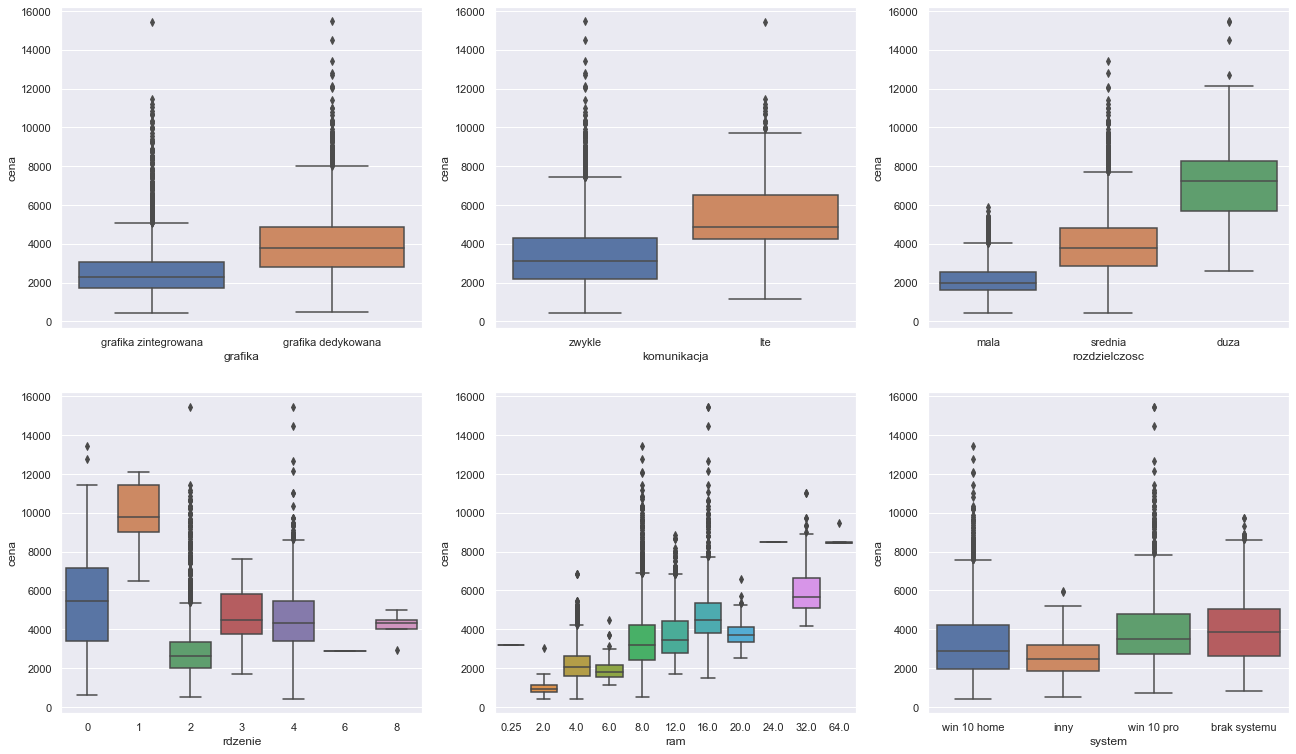

In [184]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(22, 13))

sns.boxplot(x='grafika', y='cena', data=df, ax=ax1)  
sns.boxplot(x='komunikacja', y='cena', data=df, ax=ax2)
sns.boxplot(x='rozdzielczosc', y='cena', data=df, ax=ax3)

sns.boxplot(x='rdzenie', y='cena', data=df, ax=ax4)  
sns.boxplot(x='ram', y='cena', data=df, ax=ax5)
sns.boxplot(x='system', y='cena', data=df, ax=ax6)

plt.show()

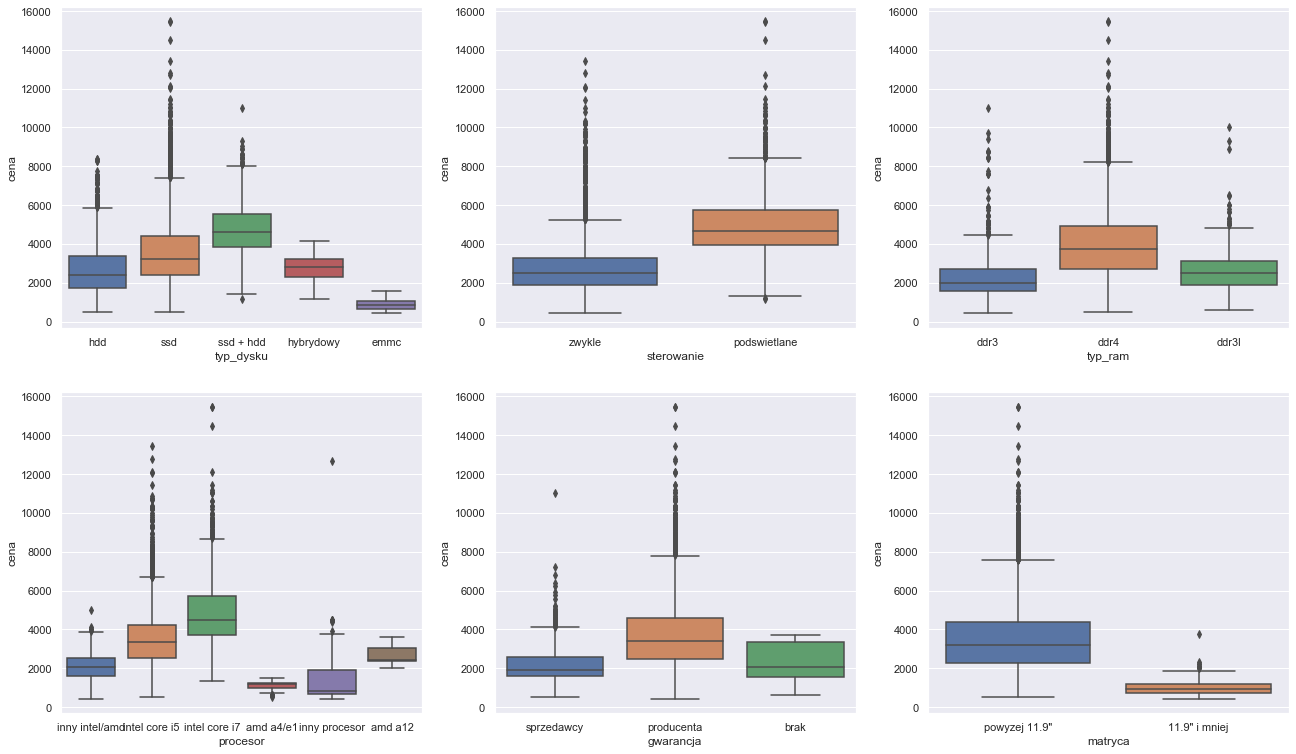

In [185]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(22, 13))

sns.boxplot(x='typ_dysku', y='cena', data=df, ax=ax1)  
sns.boxplot(x='sterowanie', y='cena', data=df, ax=ax2)
sns.boxplot(x='typ_ram', y='cena', data=df, ax=ax3)

sns.boxplot(x='procesor', y='cena', data=df, ax=ax4)  
sns.boxplot(x='gwarancja', y='cena', data=df, ax=ax5)
sns.boxplot(x='matryca', y='cena', data=df, ax=ax6)

plt.show()

### 2.3. Zmienne ilościowe

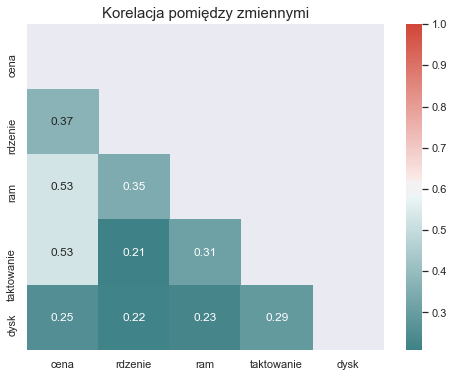

In [186]:
fig, ax = plt.subplots(figsize=(8,6))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
fig = sns.heatmap(corr, mask=mask, annot=True, cmap=sns.diverging_palette(200, 15, n=256))
ax.set_title("Korelacja pomiędzy zmiennymi", fontsize=15)

plt.show()

## 3. Przygotowanie do modelowania 

In [113]:
df.head()

,cena,grafika,komunikacja,rozdzielczosc,rdzenie,ram,system,typ_dysku,sterowanie,typ_ram,taktowanie,procesor,dysk,gwarancja,matryca
70,1599.0,grafika zintegrowana,zwykle,mala,2,8.0,win 10 home,hdd,zwykle,ddr3,1.9,inny intel/amd,500.0,sprzedawcy,"powyzej 11.9"""
1489,2999.0,grafika dedykowana,zwykle,srednia,2,12.0,win 10 home,ssd,zwykle,ddr4,2.0,inny intel/amd,480.0,producenta,"powyzej 11.9"""
407,2999.0,grafika zintegrowana,zwykle,mala,2,16.0,inny,ssd,zwykle,ddr3l,2.1,inny intel/amd,480.0,producenta,"powyzej 11.9"""
1359,2849.0,grafika zintegrowana,zwykle,srednia,2,8.0,win 10 pro,ssd,zwykle,ddr4,2.0,inny intel/amd,480.0,producenta,"powyzej 11.9"""
10567,2319.0,grafika dedykowana,zwykle,srednia,2,8.0,win 10 home,ssd,zwykle,ddr4,2.5,intel core i5,1000.0,producenta,"powyzej 11.9"""


In [114]:
df.columns

Index(['cena', 'grafika', 'komunikacja', 'rozdzielczosc', 'rdzenie', 'ram',
       'system', 'typ_dysku', 'sterowanie', 'typ_ram', 'taktowanie',
       'procesor', 'dysk', 'gwarancja', 'matryca'],
      dtype='object')

In [229]:
encoded_df = pd.get_dummies(df, columns=['grafika', 'komunikacja', 'rozdzielczosc', 'system', 'typ_dysku', 'sterowanie', 'typ_ram', 'procesor', 'gwarancja', 'matryca'], drop_first=True)

In [230]:
encoded_df

,cena,rdzenie,ram,taktowanie,dysk,grafika_grafika zintegrowana,komunikacja_zwykle,rozdzielczosc_mala,rozdzielczosc_srednia,system_inny,...,typ_ram_ddr3l,typ_ram_ddr4,procesor_amd a4/e1,procesor_inny intel/amd,procesor_inny procesor,procesor_intel core i5,procesor_intel core i7,gwarancja_producenta,gwarancja_sprzedawcy,"matryca_powyzej 11.9"""
70,1599.0,2,8.0,1.9,500,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,1
1489,2999.0,2,12.0,2.0,480,0,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1
407,2999.0,2,16.0,2.1,480,1,1,1,0,1,...,1,0,0,1,0,0,0,1,0,1
1359,2849.0,2,8.0,2.0,480,1,1,0,1,0,...,0,1,0,1,0,0,0,1,0,1
10567,2319.0,2,8.0,2.5,1000,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10541,1329.0,2,4.0,1.6,128,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,1
8281,979.0,2,8.0,2.5,32,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,1
8053,2565.0,2,4.0,2.3,128,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,1
8727,4079.0,4,16.0,2.5,1128,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,1


We need 15 features to explain 90% of the variation of the data.
We need 18 features to explain 95% of the variation of the data.
We need 22 features to explain 99% of the variation of the data.


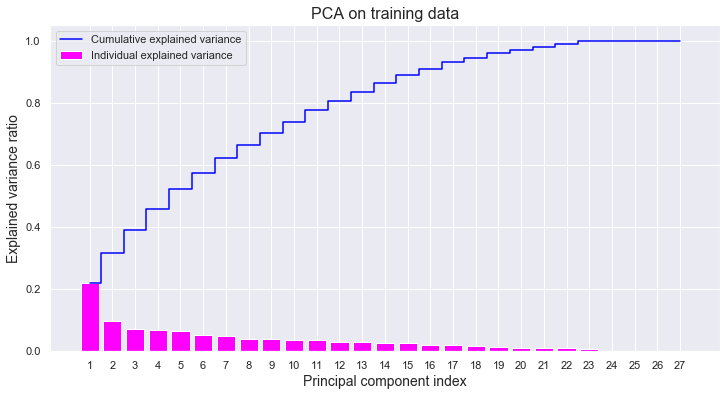

In [232]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA
pca = PCA(n_components=None, svd_solver="full")

scaler = StandardScaler()
scaler = scaler.fit_transform(encoded_df)
pca.fit(scaler)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))

n_features = len(cum_var_exp) + 1

plt.bar(range(1, n_features), pca.explained_variance_ratio_, align="center",
        color='magenta', label="Individual explained variance")

plt.step(range(1, n_features), cum_var_exp, where="mid",
         label="Cumulative explained variance", color='blue')

plt.xticks(range(1, n_features))
plt.legend(loc="best")

plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16})

# %%
print('We need', np.where(cum_var_exp > 0.90)[
      0][0], 'features to explain 90% of the variation of the data.')
print('We need', np.where(cum_var_exp > 0.95)[
      0][0], 'features to explain 95% of the variation of the data.')
print('We need', np.where(cum_var_exp > 0.99)[
      0][0], 'features to explain 99% of the variation of the data.')

In [139]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df['carrier_code'] = le.fit_transform(cat_df_flights['carrier'])


NameError: name 'lb_make' is not defined

In [233]:
from sklearn.model_selection import train_test_split


In [240]:
X = encoded_df.drop('cena', axis=1).values
y = encoded_df['cena'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [241]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [242]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=2)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[ 384.29  649.  ]
 [1555.55 1469.  ]
 [1439.07 1819.  ]
 ...
 [6012.7  7988.  ]
 [2435.95 2279.  ]
 [1881.07 1649.  ]]


In [244]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, y_pred, squared=False)
rms

915.3969609805849

In [ ]:
clfs = []

clfs.append(LogisticRegression(random_state=42))
clfs.append(SVC(random_state=42))
clfs.append(DecisionTreeClassifier(random_state=42))
clfs.append(RandomForestClassifier(random_state=42))
clfs.append(KNeighborsClassifier())
clfs.append(LinearDiscriminantAnalysis())
clfs.append(ExtraTreesClassifier(random_state=42))
clfs.append(AdaBoostClassifier(random_state=42))

cv_results = []

for clf in clfs:
    result = cross_val_score(clf, X_train, y_train,
                             scoring='f1', cv=3, n_jobs=-1)

    cv_results.append(result)

In [ ]:
cv_means = []
cv_stds = []

for result in cv_results:
    cv_means.append(result.mean())
    cv_stds.append(result.std())

algs = ['LogisticRegression', 'SVC', 'DecisionTree',
        'RandomForrest', 'KNN', 'LinearDiscriminant', 'ExtraTrees', 'AdaBoost']

df_results = pd.DataFrame({'cv_mean': cv_means, 'cv_std': cv_stds, 'algorithm': algs})

g = sns.barplot('cv_mean', 'algorithm', data=df_results,
                palette='muted', orient='h', xerr=cv_stds)

g.set_xlabel('F1 score')
g.set_title('CV Scores')

## 4. Modelowanie

## 5. Predykcja na zbiorze testowym

In [ ]:
df_test = pd.read_json("hidden-Xs.json")
df_test.columns

In [ ]:
df_test.to_csv('df_test.csv', index=False)

## Podsumowanie i wnioski

In [30]:
df_test

,rodzaj karty graficznej,komunikacja,rozdzielczość (piksele),liczba rdzeni procesora,wielkość pamięci ram,system operacyjny,typ dysku twardego,sterowanie,multimedia,typ pamięci ram,taktowanie bazowe procesora (ghz),seria procesora,stan,pojemność dysku (gb),gwarancja,wielkość matrycy
1869,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,2,20 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.0,intel core i3,nowy,240.0,producenta,"15"" - 15.9"""
10212,grafika zintegrowana,"[bluetooth, lan 10/100 mbps]",1366 x 768,2,4 gb,[windows 10 home],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,1.6,intel celeron,nowy,1000.0,producenta,"15"" - 15.9"""
7781,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.1,None,nowy,120.0,producenta,"15"" - 15.9"""
10562,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,8 gb,"[windows 8.1 home 32-bit, inny]",hdd,None,"[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.4,intel core i7,nowy,500.0,producenta,"17"" - 17.9"""
4166,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,8 gb,[brak systemu],ssd + hdd,"[klawiatura, touchpad, klawiatura podświetlana...","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,1256.0,producenta,"15"" - 15.9"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,grafika zintegrowana,"[nfc (near field communication), modem 3g (wwan)]",1920 x 1080,2,16 gb,[windows 10 professional],ssd + hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr4,2.5,intel core i5,nowy,1250.0,producenta,"15"" - 15.9"""
3876,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100/1000 mbps]",1366 x 768,2,4 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3,2.2,intel core i5,nowy,128.0,sprzedawcy,"15"" - 15.9"""
2591,grafika zintegrowana,"[bluetooth, lan 10/100/1000 mbps, lan 10/100 m...",1920 x 1080,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura podświetlana]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,512.0,producenta,"14"" - 14.9"""
1800,None,None,None,2,4 gb,None,None,"[klawiatura, touchpad]",None,None,NaN,None,nowy,1512.0,producenta,"14"" - 14.9"""
